Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking
using CmdStan, StanMCMCChain
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "05")
cd(ProjDir)

### snippet 5.1

In [3]:
wd = CSV.read(rel_path("..", "data", "WaffleDivorce.csv"), delim=';')
df = convert(DataFrame, wd);
mean_ma = mean(df[:MedianAgeMarriage])
df[:MedianAgeMarriage_s] = convert(Vector{Float64},
  (df[:MedianAgeMarriage]) .- mean_ma)/std(df[:MedianAgeMarriage]);
first(df, 5)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MedianAgeMarriage_s
,String⍰,String⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Int64⍰,Int64⍰,Int64⍰,Int64⍰,Float64⍰,Float64
1,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.60629
2,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.0,-0.686699
3,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.0,-0.204241
4,Arkansas,AR,2.92,24.3,26.4,1.7,13.5,1.22,41,1,111115,435450,0.26,-1.41039
5,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.0,0.599857


Define the Stan language model

In [4]:
ad_model = "
data {
 int < lower = 1 > N; // Sample size
 vector[N] divorce; // Predictor
 vector[N] median_age; // Outcome
}

parameters {
 real a; // Intercept
 real bA; // Slope (regression coefficients)
 real < lower = 0 > sigma; // Error SD
}

model {
  # priors
  a ~ normal(10, 10);
  bA ~ normal(0, 1);
  sigma ~ uniform(0, 10);
  # model
  divorce ~ normal(a + bA*median_age , sigma);
}
";

Define the Stanmodel and set the output format to :mcmcchain.

In [5]:
stanmodel = Stanmodel(name="MedianAgeDivorce", monitors = ["a", "bA", "sigma"],
  model=ad_model, output_format=:mcmcchain);
# Input data for cmdstan
maddata = Dict("N" => length(df[:Divorce]), "divorce" => df[:Divorce],
    "median_age" => df[:MedianAgeMarriage_s]);
# Sample using cmdstan
rc, chn, cnames = stan(stanmodel, maddata, ProjDir, diagnostics=false,
  summary=false, CmdStanDir=CMDSTAN_HOME);
# Describe the draws
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE      ESS
    a  9.6881147 0.22220733 0.0035134063 0.0039560972 1000
   bA -1.0396813 0.20915143 0.0033069745 0.0031291182 1000
sigma  1.5145867 0.15981617 0.0025269155 0.0027682514 1000

Quantiles:
         2.5%       25.0%     50.0%      75.0%       97.5%  
    a  9.2525578  9.5421025  9.684685  9.83300250 10.1311100
   bA -1.4538740 -1.1786850 -1.037915 -0.89856625 -0.6380819
sigma  1.2433937  1.3998525  1.502180  1.61382500  1.8637080



Plot the density of posterior draws

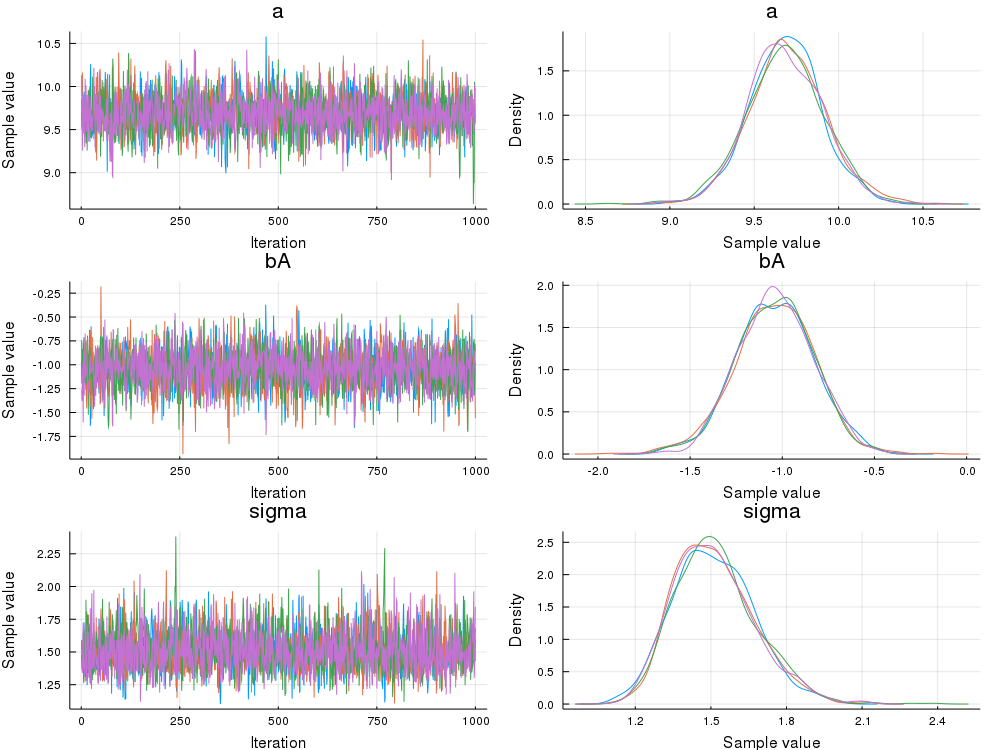

In [6]:
plot(chn)

Plot regression line using means and observations

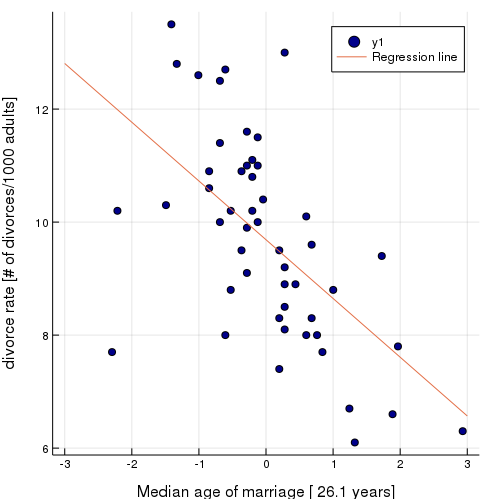

In [7]:
xi = -3.0:0.01:3.0
rws, vars, chns = size(chn[:, 1, :])
alpha_vals = convert(Vector{Float64}, reshape(chn.value[:, 1, :], (rws*chns)))
beta_vals = convert(Vector{Float64}, reshape(chn.value[:, 2, :], (rws*chns)))
yi = mean(alpha_vals) .+ mean(beta_vals)*xi

scatter(df[:MedianAgeMarriage_s], df[:Divorce], color=:darkblue,
  xlab="Median age of marriage [ $(round(mean_ma, digits=1)) years]",
  ylab="divorce rate [# of divorces/1000 adults]")
plot!(xi, yi, lab="Regression line")

shade(), abline() and link()

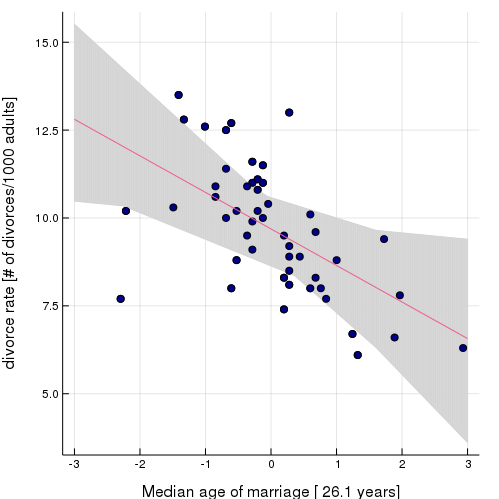

In [8]:
mu = link(xi, chn, [1, 2], mean(xi));
yl = [minimum(mu[i]) for i in 1:length(xi)];
yh =  [maximum(mu[i]) for i in 1:length(xi)];
ym =  [mean(mu[i]) for i in 1:length(xi)];
pi = hcat(xi, yl, ym, yh);
pi[1:5,:]

plot!((xi, yl), color=:lightgrey, leg=false)
plot!((xi, yh), color=:lightgrey, leg=false)
for i in 1:length(xi)
  plot!([xi[i], xi[i]], [yl[i], yh[i]], color=:lightgrey, leg=false)
end
scatter!(df[:MedianAgeMarriage_s], df[:Divorce], color=:darkblue)
plot!(xi, yi, lab="Regression line")

End of `05/clip_01s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*